In [1]:
# CODE REVIEW FILE

# Imports

In [1]:
#general imports:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import lalsimulation as lal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km


#gpu configuration:

gpu_num = 0

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2024-02-12 20:21:33.935119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 20:21:33.976819: I tens

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2024-02-12 20:21:36.330693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46258 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-02-12 20:21:36.331160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 131 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


# Functions

format_output

In [2]:
# format_output is a function used to format a pandas DataFrame (data), with 5 titled columns, into 5 np arrays.
# the function is hardcoded to accept collumn titles of gamma0, gamma1, gamma2, logp1, and logp2. 


# input: dataframe with 5 collumns
# output: 5 np arrays--one of each column


def format_output(data):
    
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_cgs_norm = data.pop('logp1_cgs_norm')
    logp1_cgs_norm = np.array(logp1_cgs_norm)
    logp2_cgs_norm = data.pop('logp2_cgs_norm')
    logp2_cgs_norm = np.array(logp2_cgs_norm)
    
    return gamma0, gamma1, gamma2, logp1_cgs_norm, logp2_cgs_norm

unnorm

In [3]:
# unorm is a function used to un-normalize the MLA outputs (predictions array) so they are plottable 
# with EOS functions. MLA values need to be un-normalizde given the MLA trains on normalized values and 
# thus outputs normalized values. The conversion from cgs to si is NOT done in this function. 

# the outputs are un-normalized with the following bounds:
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]
# log(p1) & p2 ∈ [33, 37], in cgs


# input: normalized predictions array
# output: un-normalized predictions array


def unnorm(predictionsarray):
    
    # un-normalizing the gammas and creating a seprate array for each
    new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
    new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
    new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
     
    # creating a seprate array for logp1 and logp2, still in cgs units
    cgs_logp1 = predictionsarray[3] * (37 - 33) + 33
    cgs_logp2 = predictionsarray[4] * (37 - 33) + 33
    
    #concatenating each un-normalized array (reformats)
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, cgs_logp1, cgs_logp2), axis=1)
    
    return new_array

# Data Loading

In [4]:
l1_dat = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2_dat = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
m1_dat = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2_dat = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

gamma0_real = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1_real = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2_real = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
#fix me: logp1_cgs_real, etc
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float) # in cgs
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float) # in cgs

In [5]:
count = 0
for l1,l2,m1,m2 in zip(l1_dat,l2_dat,m1_dat,m2_dat):
    if l1>10000 or l2>10000:
        count += 1
        print(count, l1,l2,m1,m2)

1 42688.433301653706 42688.433301653706 0.6741948191023934 0.4883515328474563
2 48488.88417583575 48488.88417583575 0.5825815220004984 0.3620442235538015
3 21969.64852114838 21969.64852114838 0.6363313123595115 0.606792406802843
4 105571.33372293458 105571.33372293458 0.5308486283347428 0.33706140463496265
5 11645.132784147383 11645.132784147383 0.6729777258197727 0.43380731568021674
6 19176.735872742654 19176.735872742654 0.8422047332858204 0.6329952589584973
7 10088.830562272718 10088.830562272718 0.8569006421476386 0.7381285519475804
8 132513.1771045513 132513.1771045513 0.5041665013628118 0.34178952872621915
9 67181.96286687416 67181.96286687416 0.5516070917194413 0.4999563195936593
10 12650.947058549858 12650.947058549858 0.9337364176810786 0.4722687599645371
11 54819.673553549546 54819.673553549546 0.6643684387864965 0.5426055517337482
12 115270.39104518574 115270.39104518574 0.41047323205944 0.30723046808492793
13 64140.65985590527 64140.65985590527 0.4365910184369483 0.36270590

# Preparing Data

In [6]:
datlen = len(m1_dat)

Normalizing all data that will be MLA outputs (gammas and logp's) to be between 0 and 1

In [7]:
#fix me: make a function

# bounds:

# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]
# log(p1) & p2 ∈ [33, 37], in cgs
# log(si)array = log(cgs)array - 1

#logp1_si = ((logp1_cgs - 1) - (33-1))/((37-1) - (33-1))
#logp2_si = ((logp2_cgs - 1) - (33-1))/((37-1) - (33-1))


logp1_cgs_norm = ((logp1_cgs) - (33))/((37) - (33))
logp2_cgs_norm = ((logp2_cgs) - (33))/((37) - (33))

#fix me: gamma0_norm, etc

sd_gamma0 = (gamma0_real - 1)/(5 - 1)
sd_gamma1 = (gamma1_real - 1)/(5 - 1)
sd_gamma2 = (gamma2_real - 1)/(5 - 1)

Creating an empty array of the correct size, combined_array

In [8]:
# (9) x (total num of samples in one array) to fill with data.
# 9 is for l1, l2, m1, m2, gamma0, gamma1, gamma2, logp1, and logp2. 

array_size =  np.array([[0] * 9 ] * datlen)
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)

Reformatting imported data files into combined_array

In [9]:
for i in range(datlen):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_cgs_norm[i]
    combined_array[i][8] = logp2_cgs_norm[i]

Turning combined_array into a pandas DataFrame with column titles

In [10]:
data = pd.DataFrame(combined_array)
#column titles represent m1, m2, l1, l2, gamma0, gamma1, gamma2, logp1, and logp2. 
#fix me: add _norm to column titles where needed (gamma0_norm etc)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_cgs_norm', 'logp2_cgs_norm']

# Sanity-Checking Data

Histograming imported data prior to normalization 

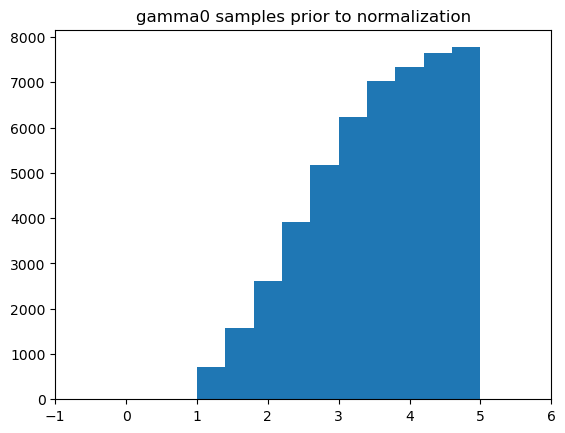

In [11]:
#gamma0
plt.hist(gamma0_real)
plt.title("gamma0 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

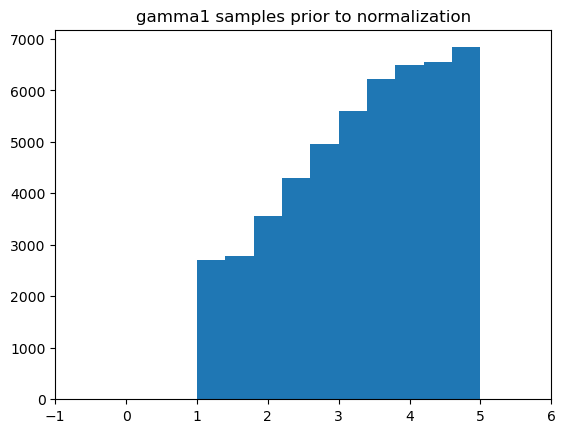

In [12]:
#gamma1
plt.hist(gamma1_real)
plt.title("gamma1 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

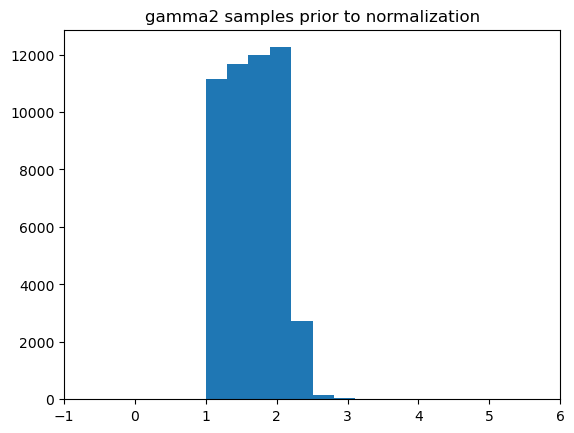

In [13]:
#gamma2
plt.hist(gamma2_real)
plt.title("gamma2 samples prior to normalization")
plt.xlim(-1, 6)
plt.show()

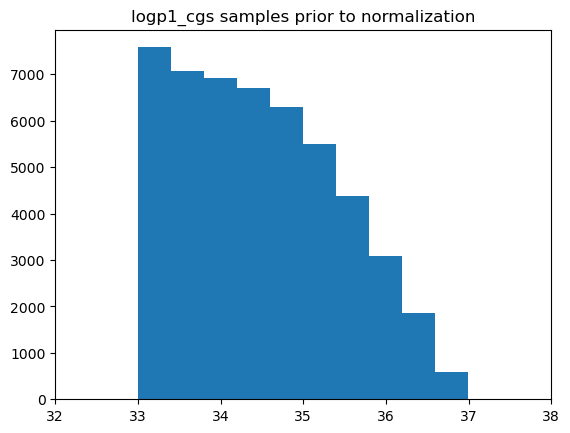

In [14]:
#logp1
plt.hist(logp1_cgs)
plt.title("logp1_cgs samples prior to normalization")
plt.xlim(32.0, 38.0)
plt.show()

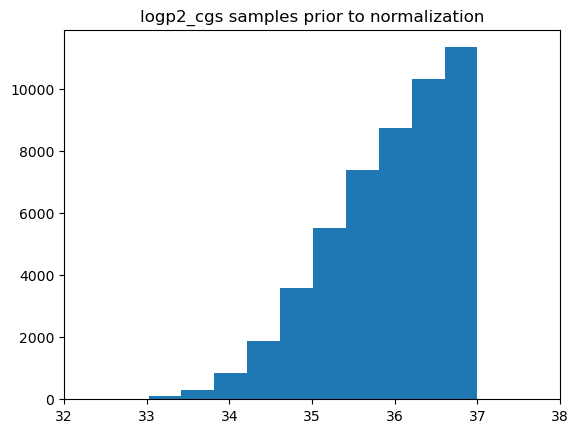

In [15]:
#logp2
plt.hist(logp2_cgs)
plt.title("logp2_cgs samples prior to normalization")
plt.xlim(32.0, 38.0)
plt.show()

Histograming imported data after to normalization 

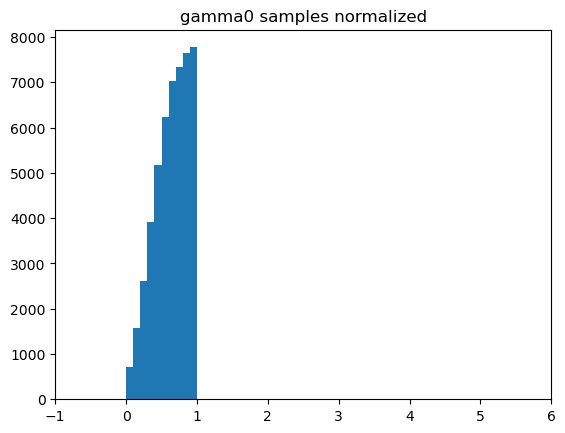

In [16]:
#gamma0
plt.hist(sd_gamma0)
plt.title("gamma0 samples normalized")
plt.xlim(-1, 6)
plt.show()

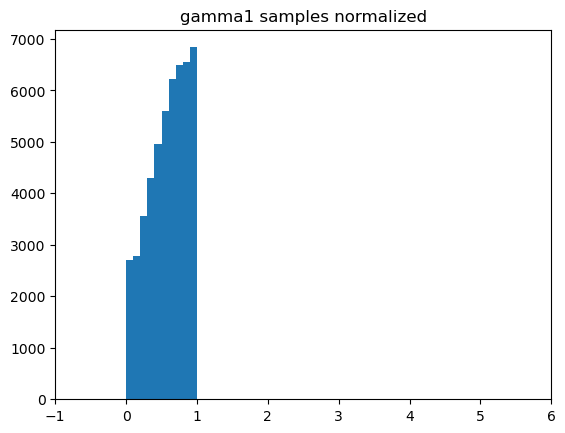

In [17]:
#gamma1
plt.hist(sd_gamma1)
plt.title("gamma1 samples normalized")
plt.xlim(-1, 6)
plt.show()

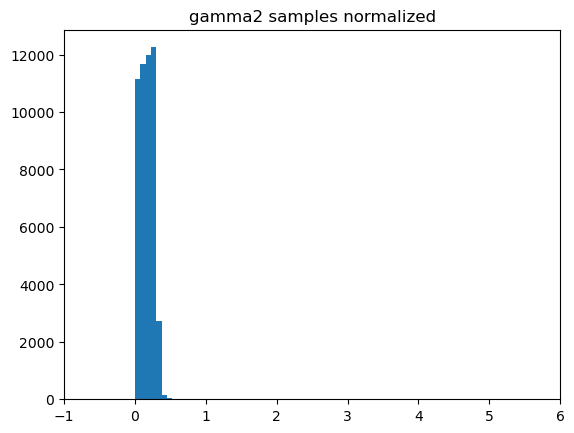

In [18]:
#gamma2
plt.hist(sd_gamma2)
plt.title("gamma2 samples normalized")
plt.xlim(-1, 6)
plt.show()

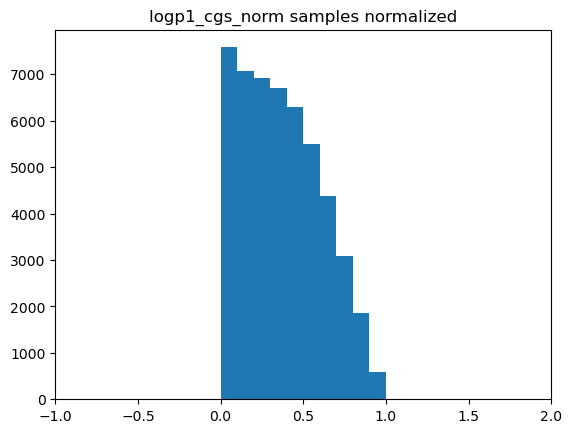

In [19]:
#logp1
plt.hist(logp1_cgs_norm)
plt.title("logp1_cgs_norm samples normalized")
plt.xlim(-1, 2)
plt.show()

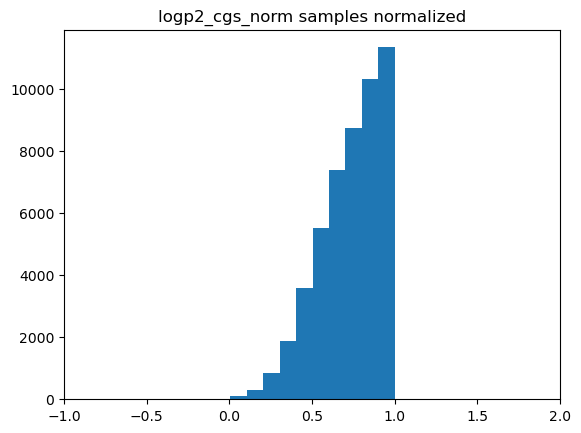

In [20]:
#logp2
plt.hist(logp2_cgs_norm)
plt.title("logp2_cgs_norm samples normalized")
plt.xlim(-1, 2)
plt.show()

# MLA Construction

Splitting the data into train and test and creating the input train & test arrays

In [21]:
# 541 total samples: 80% = 432, 20% = 108.2

# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
trainsplit = .8

train = data.iloc[:int(datlen*trainsplit),:]
test = data.iloc[int(datlen*trainsplit):,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

norm_train_X = train
norm_test_X = test

Shape of new dataframes - (40000, 9) , (10000, 9)


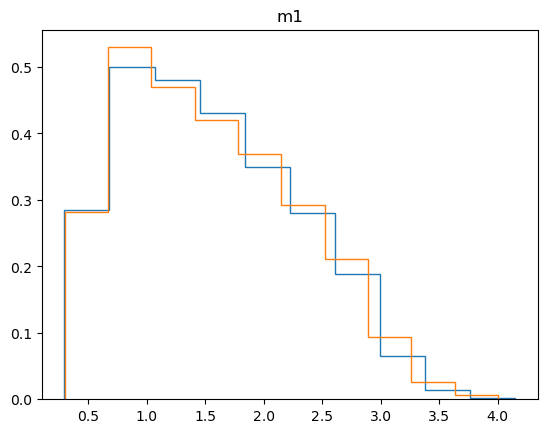

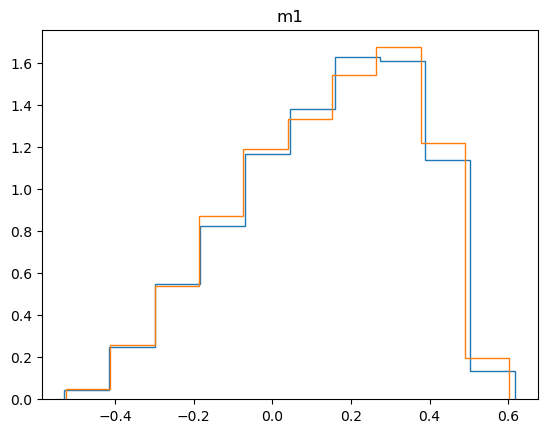

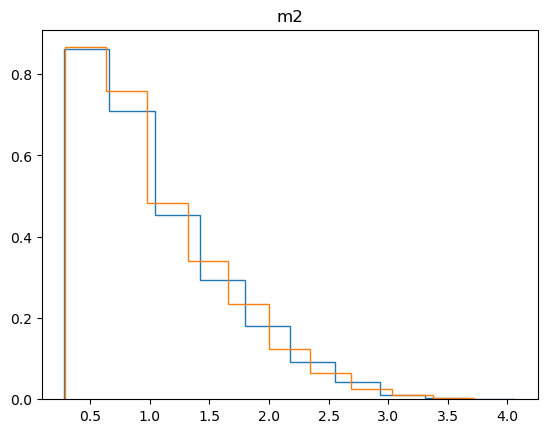

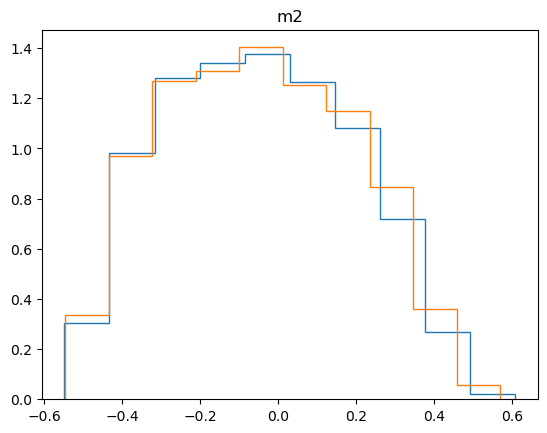

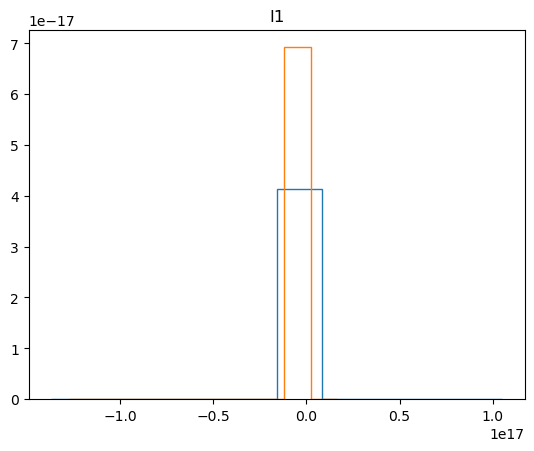

/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


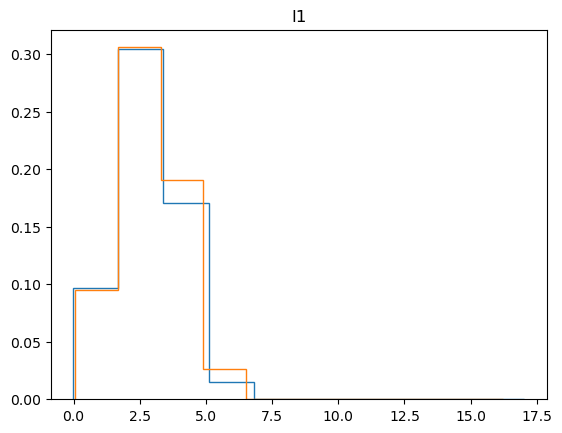

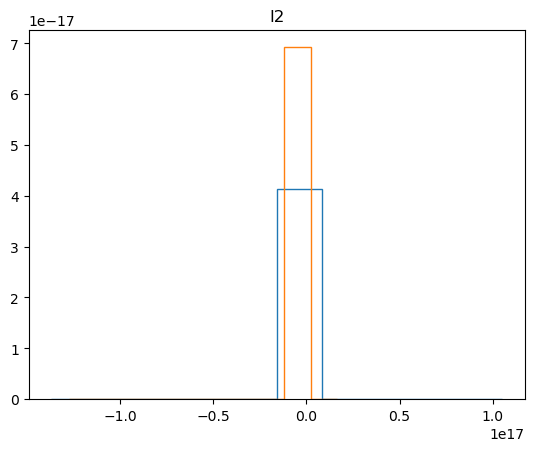

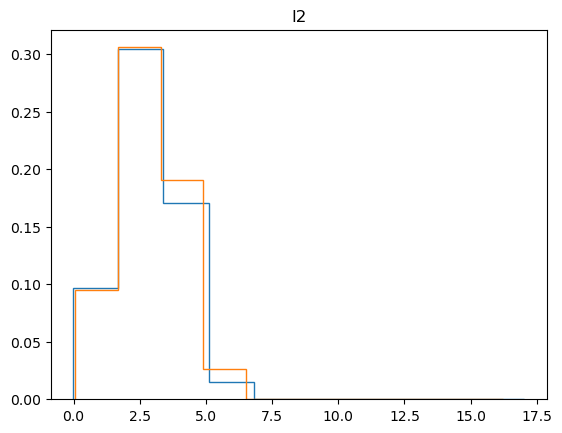

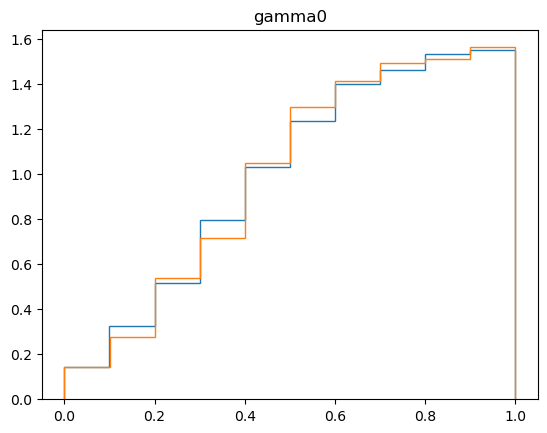

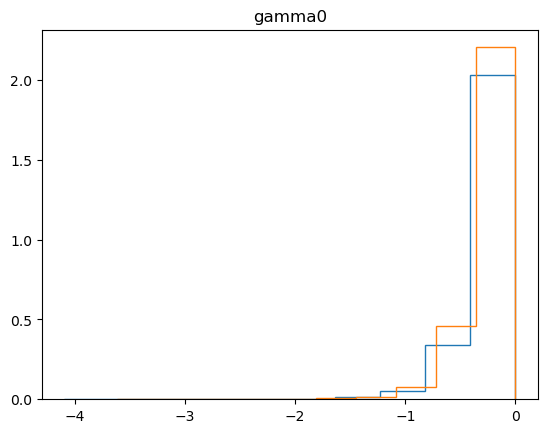

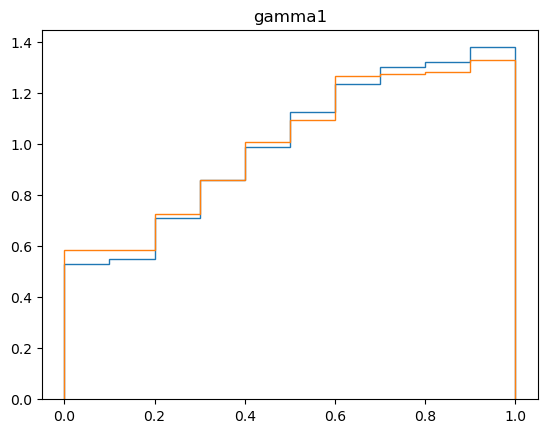

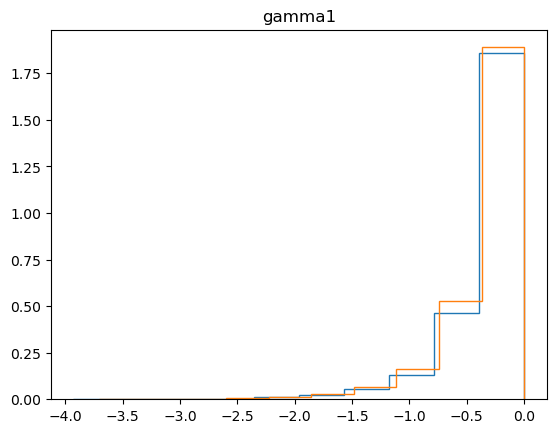

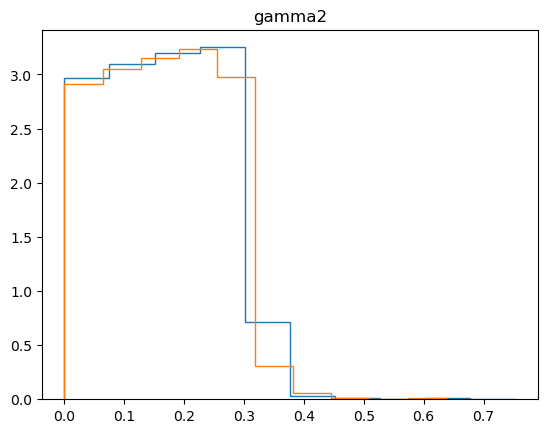

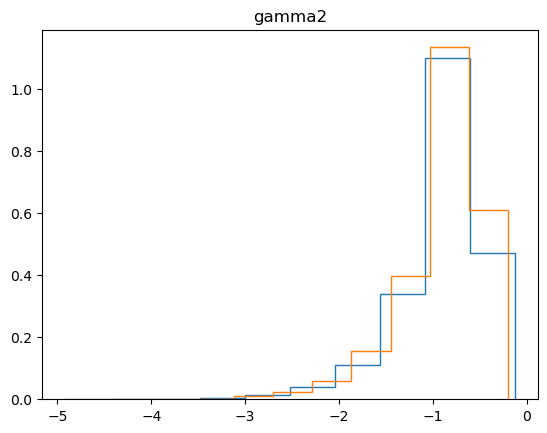

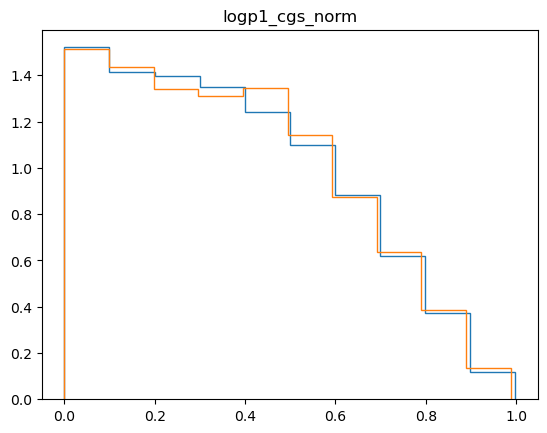

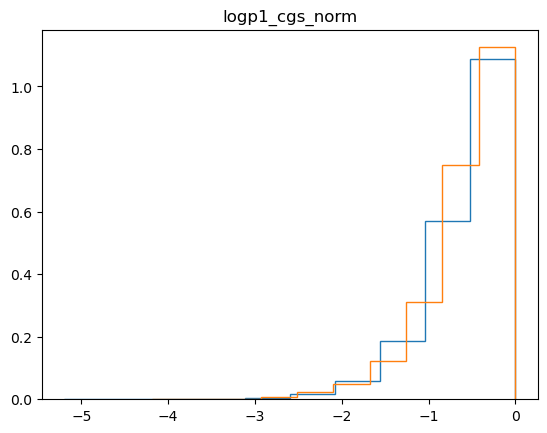

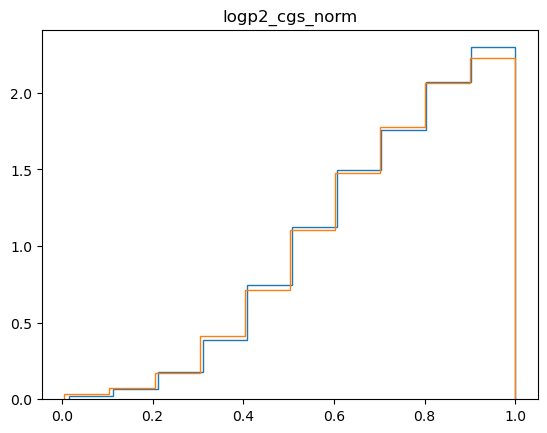

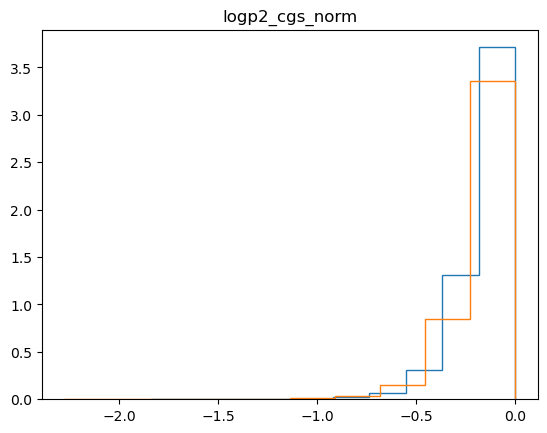

In [29]:
#sanity checking iloc

for col in data.columns:
    
    plt.hist(train[col],histtype="step",density=True)
    plt.hist(test[col],histtype="step",density=True)
    
    plt.title(col)
    plt.show()
    
    plt.hist(np.log10(train[col]),histtype="step",density=True)
    plt.hist(np.log10(test[col]),histtype="step",density=True)
    
    plt.title(col)
    plt.show()

Train statistics

In [22]:
#train_stats = train.describe()

#train_stats.pop('gamma0')
#train_stats.pop('gamma1')
#train_stats.pop('gamma2')
#train_stats.pop('logp1_cgs_norm')
#train_stats.pop('logp2_cgs_norm')
#train_stats = train_stats.transpose()

In [23]:
print(train)

             m1        m2            l1            l2    gamma0    gamma1  \
0      1.704363  0.940013     48.538860     48.538860  0.437453  0.790931   
1      0.674195  0.488352  42688.433302  42688.433302  0.648856  0.745487   
2      1.944506  1.625537    167.805410    167.805410  0.630087  0.988135   
3      0.582582  0.362044  48488.884176  48488.884176  0.479282  0.037464   
4      2.684166  2.462512     51.173074     51.173074  0.813159  0.580368   
...         ...       ...           ...           ...       ...       ...   
39995  0.902985  0.779906   4891.596113   4891.596113  0.414417  0.582457   
39996  2.770228  2.036282     16.372646     16.372646  0.220231  0.867964   
39997  2.396787  1.238727     48.060133     48.060133  0.860087  0.550972   
39998  2.502042  1.340111     93.751394     93.751394  0.844167  0.298930   
39999  0.955422  0.675658     83.024174     83.024174  0.563335  0.206376   

         gamma2  logp1_cgs_norm  logp2_cgs_norm  
0      0.034513        0.

Creating output train & test arrasy using format_output

In [24]:
train_Y = format_output(train)
test_Y = format_output(test)

In [25]:
print(train_Y)

(array([0.43745282, 0.64885557, 0.63008746, ..., 0.86008688, 0.8441673 ,
       0.5633352 ]), array([0.79093076, 0.74548714, 0.98813517, ..., 0.55097197, 0.29893013,
       0.20637615]), array([0.03451277, 0.14847173, 0.06819756, ..., 0.03748031, 0.0807912 ,
       0.26725716]), array([0.5913704 , 0.41355175, 0.59919108, ..., 0.16070344, 0.58026216,
       0.0080181 ]), array([0.69149279, 0.49844135, 0.75426551, ..., 0.91496365, 0.61542377,
       0.03627936]))


In [26]:
print(test_Y)

(array([0.59323956, 0.49594614, 0.56899179, ..., 0.57344906, 0.89969858,
       0.93761302]), array([0.17602637, 0.75650906, 0.05637736, ..., 0.78265855, 0.70166208,
       0.80852195]), array([0.30068193, 0.26723116, 0.32996798, ..., 0.27305527, 0.01230662,
       0.03616115]), array([0.47543076, 0.22421674, 0.02794   , ..., 0.0066917 , 0.57658411,
       0.44805804]), array([0.75301748, 0.28330945, 0.09495351, ..., 0.49864396, 0.65812125,
       0.55160746]))


Creating the MLA structure (adding layers)

In [35]:
len(train .columns)

4

In [36]:
input_layer = Input(shape=(len(train .columns),))

#tanh and sigmoid are selected for their capabilies in relation to the expected outputs of the MLA

layeract = 'tanh'
outputact = 'sigmoid' #nonlinear? look into

first_dense = Dense(units='128', activation=layeract)(input_layer)
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_output = Dense(units='1', activation=outputact, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='64', activation=layeract)(thf_dense)
tht_dense = Dense(units='64', activation=layeract)(ths_dense)
thfo_dense = Dense(units='64', activation=layeract)(tht_dense)
thfi_dense = Dense(units='64', activation=layeract)(thfo_dense)
ths_dense = Dense(units='64', activation=layeract)(thfi_dense)
thse_dense = Dense(units='64', activation=layeract)(ths_dense)
the_dense = Dense(units='64', activation=layeract)(thse_dense)
thn_dense = Dense(units='64', activation=layeract)(the_dense)

gamma1_output = Dense(units='1', activation=outputact, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='32', activation=layeract)(fo_dense)
fos_dense = Dense(units='32', activation=layeract)(fof_dense)
fot_dense = Dense(units='32', activation=layeract)(fos_dense)
fofo_dense = Dense(units='32', activation=layeract)(fot_dense)
fofi_dense = Dense(units='32', activation=layeract)(fofo_dense)

gamma2_output = Dense(units='1', activation=outputact, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='16', activation=layeract)(fos_dense)
foe_dense = Dense(units='16', activation=layeract)(fose_dense)
fon_dense = Dense(units='16', activation=layeract)(foe_dense)
fif_dense = Dense(units='16', activation=layeract)(fon_dense)

logp1_cgs_norm_output = Dense(units='1', activation=outputact, name='logp1_cgs_norm_output')(fif_dense)
fiff_dense = Dense(units='8', activation=layeract)(fif_dense)

fifs_dense = Dense(units='8', activation=layeract)(fiff_dense)
fift_dense = Dense(units='8', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='8', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='8', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='8', activation=layeract)(fiffi_dense)

logp2_cgs_norm_output = Dense(units='1', activation=outputact, name='logp2_cgs_norm_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_cgs_norm_output, logp2_cgs_norm_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                              

 dense_39 (Dense)            (None, 32)                   1056      ['dense_38[0][0]']            
                                                                                                  
 dense_40 (Dense)            (None, 32)                   1056      ['dense_39[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 32)                   1056      ['dense_40[0][0]']            
                                                                                                  
 dense_42 (Dense)            (None, 32)                   1056      ['dense_41[0][0]']            
                                                                                                  
 dense_43 (Dense)            (None, 32)                   1056      ['dense_42[0][0]']            
                                                                                                  
 dense_44 

Specifying the optimizer as stochastic gradient descent and learning rate as 0.001, as well as compiling the model with loss metrics

In [37]:
#the mean squared error loss is chosen for this MLA as it us compatable with the ANN

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_cgs_norm_output': 'mse', 'logp2_cgs_norm_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_cgs_norm_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_cgs_norm_output': tf.keras.metrics.MeanSquaredError()
                      })

#this string is saved for later, when plotting loss. 
endmetric = "mean_squared_error"

# MLA Training

In [38]:
#train the model for a number of epochs
#fix me: for the future, hyper-parameter tune

numepochs = 500
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=150,mode='auto')])


Epoch 1/500


2024-01-31 10:13:51.516116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-31 10:13:51.518191: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x148af1cf4890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 10:13:51.518206: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-31 10:13:51.518209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-31 10:13:51.521451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-31 10:13:51.660222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-31 10:13:51.73583

3200/3200 [==============================] - 38s 9ms/step - loss: 0.2260 - gamma0_output_loss: 0.0515 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0094 - logp1_cgs_norm_output_loss: 0.0570 - logp2_cgs_norm_output_loss: 0.0358 - gamma0_output_mean_squared_error: 0.0515 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0094 - logp1_cgs_norm_output_mean_squared_error: 0.0570 - logp2_cgs_norm_output_mean_squared_error: 0.0358 - val_loss: 0.2136 - val_gamma0_output_loss: 0.0415 - val_gamma1_output_loss: 0.0722 - val_gamma2_output_loss: 0.0091 - val_logp1_cgs_norm_output_loss: 0.0562 - val_logp2_cgs_norm_output_loss: 0.0347 - val_gamma0_output_mean_squared_error: 0.0415 - val_gamma1_output_mean_squared_error: 0.0722 - val_gamma2_output_mean_squared_error: 0.0091 - val_logp1_cgs_norm_output_mean_squared_error: 0.0562 - val_logp2_cgs_norm_output_mean_squared_error: 0.0347
Epoch 2/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2170

Epoch 10/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2121 - gamma0_output_loss: 0.0404 - gamma1_output_loss: 0.0715 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0563 - logp2_cgs_norm_output_loss: 0.0350 - gamma0_output_mean_squared_error: 0.0404 - gamma1_output_mean_squared_error: 0.0715 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0563 - logp2_cgs_norm_output_mean_squared_error: 0.0350 - val_loss: 0.2116 - val_gamma0_output_loss: 0.0396 - val_gamma1_output_loss: 0.0725 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0560 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0396 - val_gamma1_output_mean_squared_error: 0.0725 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0560 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 11/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 19/500
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2093 - gamma0_output_loss: 0.0382 - gamma1_output_loss: 0.0713 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0560 - logp2_cgs_norm_output_loss: 0.0349 - gamma0_output_mean_squared_error: 0.0382 - gamma1_output_mean_squared_error: 0.0713 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0560 - logp2_cgs_norm_output_mean_squared_error: 0.0349 - val_loss: 0.2093 - val_gamma0_output_loss: 0.0377 - val_gamma1_output_loss: 0.0722 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0557 - val_logp2_cgs_norm_output_loss: 0.0347 - val_gamma0_output_mean_squared_error: 0.0377 - val_gamma1_output_mean_squared_error: 0.0722 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0557 - val_logp2_cgs_norm_output_mean_squared_error: 0.0347
Epoch 20/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 28/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2080 - gamma0_output_loss: 0.0371 - gamma1_output_loss: 0.0712 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0560 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0371 - gamma1_output_mean_squared_error: 0.0712 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0560 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2025 - val_gamma0_output_loss: 0.0321 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0321 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 29/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 37/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2077 - gamma0_output_loss: 0.0367 - gamma1_output_loss: 0.0712 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0560 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0367 - gamma1_output_mean_squared_error: 0.0712 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0560 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2063 - val_gamma0_output_loss: 0.0348 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0559 - val_logp2_cgs_norm_output_loss: 0.0346 - val_gamma0_output_mean_squared_error: 0.0348 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0559 - val_logp2_cgs_norm_output_mean_squared_error: 0.0346
Epoch 38/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 46/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2076 - gamma0_output_loss: 0.0365 - gamma1_output_loss: 0.0714 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0560 - logp2_cgs_norm_output_loss: 0.0349 - gamma0_output_mean_squared_error: 0.0365 - gamma1_output_mean_squared_error: 0.0714 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0560 - logp2_cgs_norm_output_mean_squared_error: 0.0349 - val_loss: 0.2092 - val_gamma0_output_loss: 0.0373 - val_gamma1_output_loss: 0.0722 - val_gamma2_output_loss: 0.0091 - val_logp1_cgs_norm_output_loss: 0.0563 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0373 - val_gamma1_output_mean_squared_error: 0.0722 - val_gamma2_output_mean_squared_error: 0.0091 - val_logp1_cgs_norm_output_mean_squared_error: 0.0563 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 47/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 55/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2072 - gamma0_output_loss: 0.0363 - gamma1_output_loss: 0.0713 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0559 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0363 - gamma1_output_mean_squared_error: 0.0713 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0559 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2014 - val_gamma0_output_loss: 0.0291 - val_gamma1_output_loss: 0.0726 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0554 - val_logp2_cgs_norm_output_loss: 0.0354 - val_gamma0_output_mean_squared_error: 0.0291 - val_gamma1_output_mean_squared_error: 0.0726 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0554 - val_logp2_cgs_norm_output_mean_squared_error: 0.0354
Epoch 56/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 64/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2054 - gamma0_output_loss: 0.0348 - gamma1_output_loss: 0.0712 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0558 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0348 - gamma1_output_mean_squared_error: 0.0712 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0558 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2085 - val_gamma0_output_loss: 0.0372 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0559 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0372 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0559 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 65/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 73/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2053 - gamma0_output_loss: 0.0348 - gamma1_output_loss: 0.0711 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0558 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0348 - gamma1_output_mean_squared_error: 0.0711 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0558 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2035 - val_gamma0_output_loss: 0.0324 - val_gamma1_output_loss: 0.0724 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0554 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0324 - val_gamma1_output_mean_squared_error: 0.0724 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0554 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 74/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 82/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2050 - gamma0_output_loss: 0.0346 - gamma1_output_loss: 0.0711 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0558 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0346 - gamma1_output_mean_squared_error: 0.0711 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0558 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2076 - val_gamma0_output_loss: 0.0355 - val_gamma1_output_loss: 0.0726 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0559 - val_logp2_cgs_norm_output_loss: 0.0347 - val_gamma0_output_mean_squared_error: 0.0355 - val_gamma1_output_mean_squared_error: 0.0726 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0559 - val_logp2_cgs_norm_output_mean_squared_error: 0.0347
Epoch 83/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 91/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2056 - gamma0_output_loss: 0.0350 - gamma1_output_loss: 0.0711 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0558 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0350 - gamma1_output_mean_squared_error: 0.0711 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0558 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.1989 - val_gamma0_output_loss: 0.0284 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0284 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 92/500
3200/3200 [==============================] - 25s 8ms/step 

Epoch 100/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2046 - gamma0_output_loss: 0.0342 - gamma1_output_loss: 0.0711 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0342 - gamma1_output_mean_squared_error: 0.0711 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2028 - val_gamma0_output_loss: 0.0322 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0554 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0322 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0554 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 101/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 109/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2064 - gamma0_output_loss: 0.0356 - gamma1_output_loss: 0.0712 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0559 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0356 - gamma1_output_mean_squared_error: 0.0712 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0559 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2052 - val_gamma0_output_loss: 0.0339 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0555 - val_logp2_cgs_norm_output_loss: 0.0346 - val_gamma0_output_mean_squared_error: 0.0339 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0555 - val_logp2_cgs_norm_output_mean_squared_error: 0.0346
Epoch 110/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 118/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2051 - gamma0_output_loss: 0.0346 - gamma1_output_loss: 0.0712 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0346 - gamma1_output_mean_squared_error: 0.0712 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2053 - val_gamma0_output_loss: 0.0337 - val_gamma1_output_loss: 0.0722 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0559 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0337 - val_gamma1_output_mean_squared_error: 0.0722 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0559 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 119/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 127/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2041 - gamma0_output_loss: 0.0338 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0338 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2009 - val_gamma0_output_loss: 0.0304 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0304 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 128/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 136/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2037 - gamma0_output_loss: 0.0333 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0333 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1996 - val_gamma0_output_loss: 0.0293 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0293 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 137/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 145/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2035 - gamma0_output_loss: 0.0332 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0332 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1990 - val_gamma0_output_loss: 0.0287 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0287 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 146/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 154/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2027 - gamma0_output_loss: 0.0326 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0326 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2160 - val_gamma0_output_loss: 0.0447 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0558 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0447 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0558 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 155/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 163/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2032 - gamma0_output_loss: 0.0330 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0330 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2001 - val_gamma0_output_loss: 0.0298 - val_gamma1_output_loss: 0.0717 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0553 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0298 - val_gamma1_output_mean_squared_error: 0.0717 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0553 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 164/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 172/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2030 - gamma0_output_loss: 0.0328 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0328 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2009 - val_gamma0_output_loss: 0.0304 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0304 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 173/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 181/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2027 - gamma0_output_loss: 0.0325 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0325 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2012 - val_gamma0_output_loss: 0.0307 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0553 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0307 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0553 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 182/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 190/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2024 - gamma0_output_loss: 0.0322 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0322 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2113 - val_gamma0_output_loss: 0.0397 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0561 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0397 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0561 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 191/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 199/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2022 - gamma0_output_loss: 0.0321 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0321 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2003 - val_gamma0_output_loss: 0.0303 - val_gamma1_output_loss: 0.0717 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0303 - val_gamma1_output_mean_squared_error: 0.0717 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 200/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 208/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2021 - gamma0_output_loss: 0.0321 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0321 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1998 - val_gamma0_output_loss: 0.0296 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0296 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 209/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 217/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2019 - gamma0_output_loss: 0.0318 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0318 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2032 - val_gamma0_output_loss: 0.0328 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0553 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0328 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0553 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 218/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 226/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2018 - gamma0_output_loss: 0.0317 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0317 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1995 - val_gamma0_output_loss: 0.0290 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0290 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 227/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 235/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2019 - gamma0_output_loss: 0.0318 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0318 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2008 - val_gamma0_output_loss: 0.0300 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0556 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0300 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0556 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 236/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 244/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2019 - gamma0_output_loss: 0.0318 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0318 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1988 - val_gamma0_output_loss: 0.0289 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0289 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 245/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 253/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2014 - gamma0_output_loss: 0.0313 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0313 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2129 - val_gamma0_output_loss: 0.0423 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0423 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 254/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 262/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2016 - gamma0_output_loss: 0.0315 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0315 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1959 - val_gamma0_output_loss: 0.0263 - val_gamma1_output_loss: 0.0717 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0547 - val_logp2_cgs_norm_output_loss: 0.0342 - val_gamma0_output_mean_squared_error: 0.0263 - val_gamma1_output_mean_squared_error: 0.0717 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0547 - val_logp2_cgs_norm_output_mean_squared_error: 0.0342
Epoch 263/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 271/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2014 - gamma0_output_loss: 0.0314 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0314 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1997 - val_gamma0_output_loss: 0.0296 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0296 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 272/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 280/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2015 - gamma0_output_loss: 0.0314 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0314 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2030 - val_gamma0_output_loss: 0.0326 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0346 - val_gamma0_output_mean_squared_error: 0.0326 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0346
Epoch 281/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 289/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2015 - gamma0_output_loss: 0.0315 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0315 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1986 - val_gamma0_output_loss: 0.0284 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0284 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 290/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 298/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2013 - gamma0_output_loss: 0.0313 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0313 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2030 - val_gamma0_output_loss: 0.0322 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0555 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0322 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0555 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 299/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 307/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2015 - gamma0_output_loss: 0.0314 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0314 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1994 - val_gamma0_output_loss: 0.0285 - val_gamma1_output_loss: 0.0722 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0554 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0285 - val_gamma1_output_mean_squared_error: 0.0722 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0554 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 308/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 316/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2013 - gamma0_output_loss: 0.0313 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0313 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1994 - val_gamma0_output_loss: 0.0293 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0293 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 317/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 325/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2006 - gamma0_output_loss: 0.0308 - gamma1_output_loss: 0.0708 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0308 - gamma1_output_mean_squared_error: 0.0708 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1997 - val_gamma0_output_loss: 0.0296 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0296 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 326/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 334/500
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2026 - gamma0_output_loss: 0.0324 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0324 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2062 - val_gamma0_output_loss: 0.0352 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0555 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0352 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0555 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 335/500
3200/3200 [==============================] - 28s 9ms/ste

Epoch 343/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2021 - gamma0_output_loss: 0.0317 - gamma1_output_loss: 0.0711 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0348 - gamma0_output_mean_squared_error: 0.0317 - gamma1_output_mean_squared_error: 0.0711 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0348 - val_loss: 0.2097 - val_gamma0_output_loss: 0.0359 - val_gamma1_output_loss: 0.0726 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0570 - val_logp2_cgs_norm_output_loss: 0.0351 - val_gamma0_output_mean_squared_error: 0.0359 - val_gamma1_output_mean_squared_error: 0.0726 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0570 - val_logp2_cgs_norm_output_mean_squared_error: 0.0351
Epoch 344/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 352/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2021 - gamma0_output_loss: 0.0318 - gamma1_output_loss: 0.0710 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0557 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0318 - gamma1_output_mean_squared_error: 0.0710 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0557 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1986 - val_gamma0_output_loss: 0.0280 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0280 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 353/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 361/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2010 - gamma0_output_loss: 0.0310 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0310 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1975 - val_gamma0_output_loss: 0.0276 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0548 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0276 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0548 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 362/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 370/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2006 - gamma0_output_loss: 0.0307 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0307 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2021 - val_gamma0_output_loss: 0.0318 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0318 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 371/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 379/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2003 - gamma0_output_loss: 0.0305 - gamma1_output_loss: 0.0708 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0554 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0305 - gamma1_output_mean_squared_error: 0.0708 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0554 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1989 - val_gamma0_output_loss: 0.0286 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0286 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 380/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 388/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.1999 - gamma0_output_loss: 0.0301 - gamma1_output_loss: 0.0708 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0301 - gamma1_output_mean_squared_error: 0.0708 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1950 - val_gamma0_output_loss: 0.0248 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0248 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 389/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 397/500
3200/3200 [==============================] - 27s 8ms/step - loss: 0.2006 - gamma0_output_loss: 0.0306 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0306 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1972 - val_gamma0_output_loss: 0.0267 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0553 - val_logp2_cgs_norm_output_loss: 0.0345 - val_gamma0_output_mean_squared_error: 0.0267 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0553 - val_logp2_cgs_norm_output_mean_squared_error: 0.0345
Epoch 398/500
3200/3200 [==============================] - 27s 9ms/ste

Epoch 406/500
3200/3200 [==============================] - 28s 9ms/step - loss: 0.1997 - gamma0_output_loss: 0.0299 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0554 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0299 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0554 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2004 - val_gamma0_output_loss: 0.0299 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0299 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 407/500
3200/3200 [==============================] - 27s 8ms/ste

Epoch 415/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2001 - gamma0_output_loss: 0.0304 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0554 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0304 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0554 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2005 - val_gamma0_output_loss: 0.0303 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0342 - val_gamma0_output_mean_squared_error: 0.0303 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0342
Epoch 416/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 424/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2004 - gamma0_output_loss: 0.0305 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0305 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2011 - val_gamma0_output_loss: 0.0307 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0307 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 425/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 433/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2004 - gamma0_output_loss: 0.0305 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0305 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.2037 - val_gamma0_output_loss: 0.0331 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0554 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0331 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0554 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 434/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 442/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2001 - gamma0_output_loss: 0.0303 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0554 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0303 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0554 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2027 - val_gamma0_output_loss: 0.0323 - val_gamma1_output_loss: 0.0720 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0551 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0323 - val_gamma1_output_mean_squared_error: 0.0720 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0551 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 443/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 451/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2016 - gamma0_output_loss: 0.0315 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0315 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2020 - val_gamma0_output_loss: 0.0303 - val_gamma1_output_loss: 0.0721 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0561 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0303 - val_gamma1_output_mean_squared_error: 0.0721 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0561 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 452/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 460/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2001 - gamma0_output_loss: 0.0301 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0301 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1974 - val_gamma0_output_loss: 0.0272 - val_gamma1_output_loss: 0.0717 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0552 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0272 - val_gamma1_output_mean_squared_error: 0.0717 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0552 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 461/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 469/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2000 - gamma0_output_loss: 0.0301 - gamma1_output_loss: 0.0708 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0556 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0301 - gamma1_output_mean_squared_error: 0.0708 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0556 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1958 - val_gamma0_output_loss: 0.0259 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0548 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0259 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0548 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 470/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 478/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.1997 - gamma0_output_loss: 0.0299 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0299 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.2008 - val_gamma0_output_loss: 0.0301 - val_gamma1_output_loss: 0.0718 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0556 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0301 - val_gamma1_output_mean_squared_error: 0.0718 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0556 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 479/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 487/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.1997 - gamma0_output_loss: 0.0300 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0554 - logp2_cgs_norm_output_loss: 0.0346 - gamma0_output_mean_squared_error: 0.0300 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0554 - logp2_cgs_norm_output_mean_squared_error: 0.0346 - val_loss: 0.1967 - val_gamma0_output_loss: 0.0269 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0549 - val_logp2_cgs_norm_output_loss: 0.0343 - val_gamma0_output_mean_squared_error: 0.0269 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0549 - val_logp2_cgs_norm_output_mean_squared_error: 0.0343
Epoch 488/500
3200/3200 [==============================] - 25s 8ms/ste

Epoch 496/500
3200/3200 [==============================] - 25s 8ms/step - loss: 0.2004 - gamma0_output_loss: 0.0305 - gamma1_output_loss: 0.0709 - gamma2_output_loss: 0.0089 - logp1_cgs_norm_output_loss: 0.0555 - logp2_cgs_norm_output_loss: 0.0347 - gamma0_output_mean_squared_error: 0.0305 - gamma1_output_mean_squared_error: 0.0709 - gamma2_output_mean_squared_error: 0.0089 - logp1_cgs_norm_output_mean_squared_error: 0.0555 - logp2_cgs_norm_output_mean_squared_error: 0.0347 - val_loss: 0.1967 - val_gamma0_output_loss: 0.0266 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0090 - val_logp1_cgs_norm_output_loss: 0.0550 - val_logp2_cgs_norm_output_loss: 0.0344 - val_gamma0_output_mean_squared_error: 0.0266 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0090 - val_logp1_cgs_norm_output_mean_squared_error: 0.0550 - val_logp2_cgs_norm_output_mean_squared_error: 0.0344
Epoch 497/500
3200/3200 [==============================] - 25s 8ms/ste

# MLA Evaluating

Running model.evaluate

In [40]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_cgs_norm_loss, logp1_cgs_norm_accuracy, logp2_cgs_norm_loss, logp2_cgs_norm_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


313/313 [==============================] - 1s 3ms/step - loss: 0.1997 - gamma0_output_loss: 0.0270 - gamma1_output_loss: 0.0722 - gamma2_output_loss: 0.0088 - logp1_cgs_norm_output_loss: 0.0551 - logp2_cgs_norm_output_loss: 0.0366 - gamma0_output_mean_squared_error: 0.0270 - gamma1_output_mean_squared_error: 0.0722 - gamma2_output_mean_squared_error: 0.0088 - logp1_cgs_norm_output_mean_squared_error: 0.0551 - logp2_cgs_norm_output_mean_squared_error: 0.0366


Running model.predict and generating predictions

In [41]:
new_predictions = model.predict(norm_train_X.to_numpy())

1250/1250 [==============================] - 3s 2ms/step


Un-normalizing predictions with unnorm

In [42]:
predictions = unnorm(new_predictions)

# Reviewing the MLA Predictions

Histograming still normalized MLA predictions, still in cgs

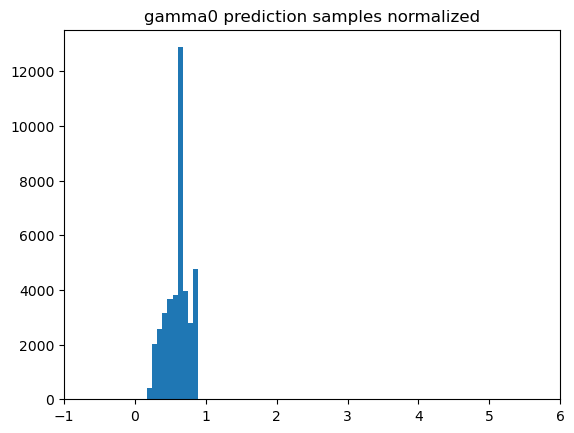

In [43]:
plt.hist(new_predictions[0])
plt.title("gamma0 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

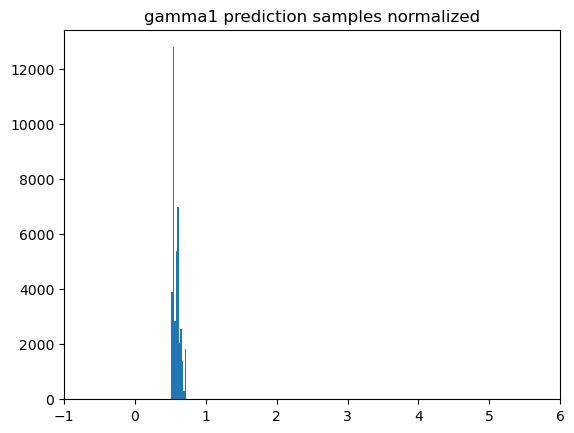

In [44]:
plt.hist(new_predictions[1])
plt.title("gamma1 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

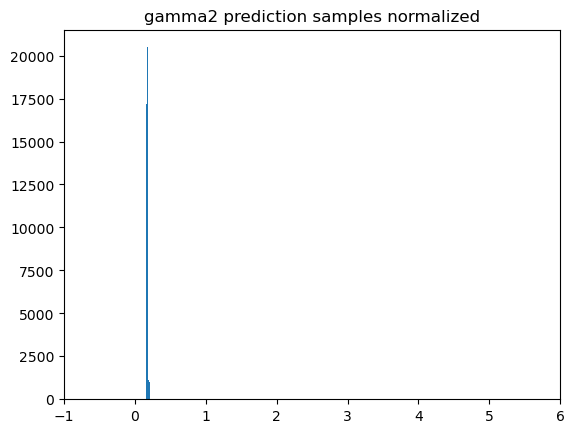

In [45]:
plt.hist(new_predictions[2])
plt.title("gamma2 prediction samples normalized")
plt.xlim(-1, 6)
plt.show()

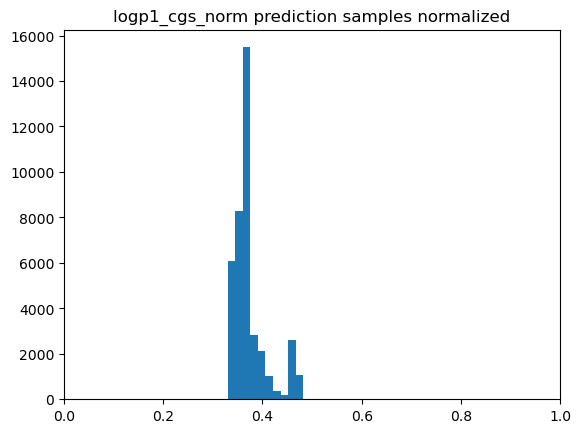

In [46]:
plt.hist(new_predictions[3])
plt.title("logp1_cgs_norm prediction samples normalized")
plt.xlim(0,1)
plt.show()

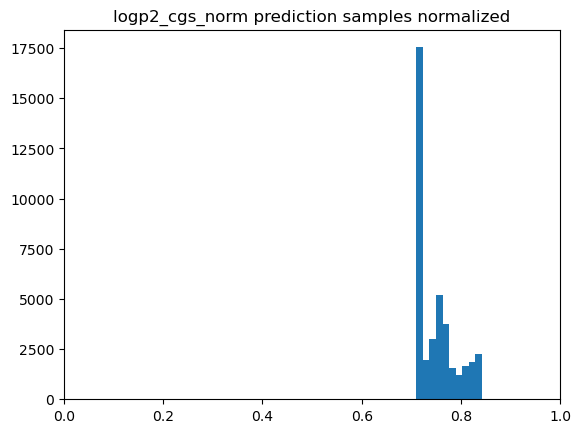

In [47]:
plt.hist(new_predictions[4])
plt.title("logp2_cgs_norm prediction samples normalized")
plt.xlim(0,1)
plt.show()

Histograming un-normalized MLA predictions, still in cgs

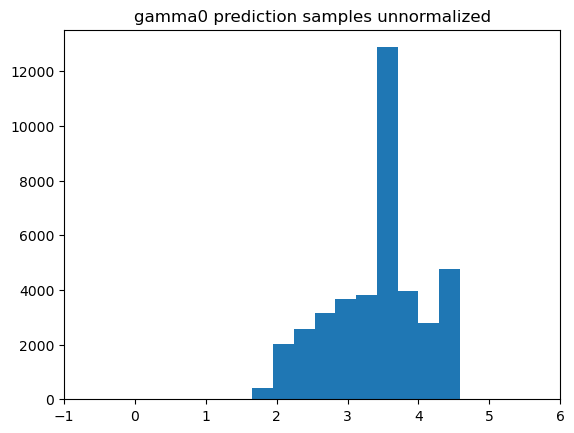

In [48]:
normgam0ar = []
for i in range (len(predictions)):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

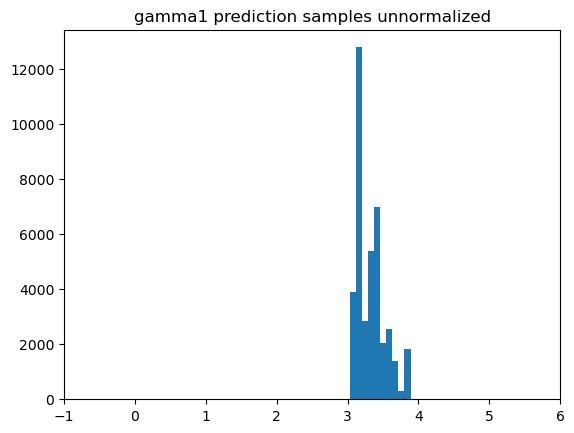

In [49]:
normgam1ar = []
for i in range (len(predictions)):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

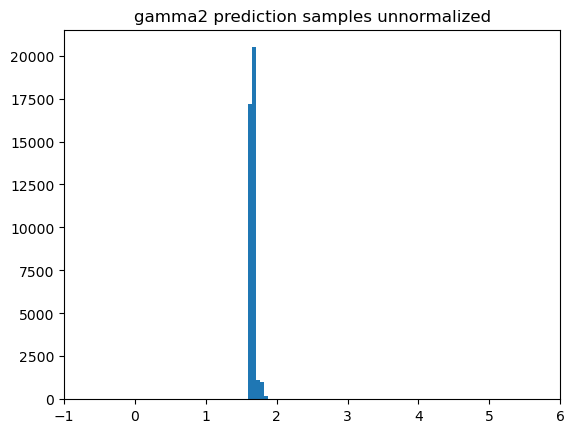

In [50]:
normgam2ar = []
for i in range (len(predictions)):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 prediction samples unnormalized")
plt.xlim(-1, 6)
plt.show()

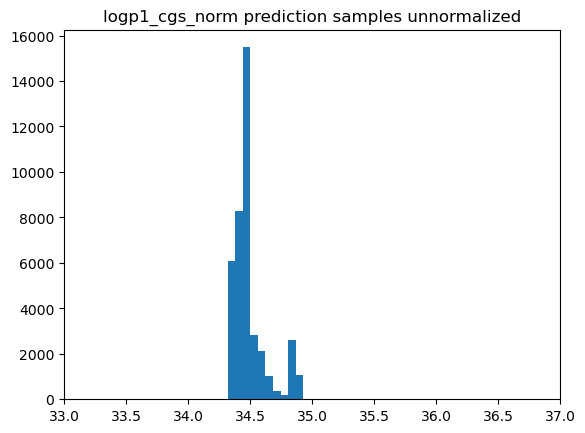

In [51]:
normlogp1ar = []
for i in range (len(predictions)):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_cgs_norm prediction samples unnormalized")
plt.xlim(33, 37)
plt.show()

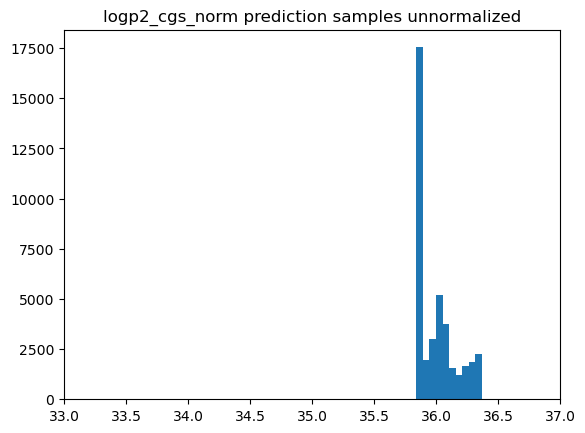

In [52]:
normlogp2ar = []
for i in range (len(predictions)):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_cgs_norm prediction samples unnormalized")
plt.xlim(33, 37)
plt.show()

# Plot one EOS

Collecting one predicted value from each set of predicted data, converting to si

In [53]:
# log(si)array = log(cgs)array - 1

fgam0 = float(predictions[0][0])
print(fgam0)
fgam1 = float(predictions[0][1])
print(fgam1)
fgam2 = float(predictions[0][2])
print(fgam2)
flogp1 = float(predictions[0][3] -1)
print(flogp1)
flogp2 = float(predictions[0][4] -1) 
print(flogp2)

2.478745222091675
3.303621530532837
1.6846578121185303
33.39942932128906
35.11860275268555


Creating one EOS line

In [54]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

Building the logdensity and logpressure space fro the one EOS line

In [55]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Plotting the EOS

Text(0, 0.5, 'pressure')

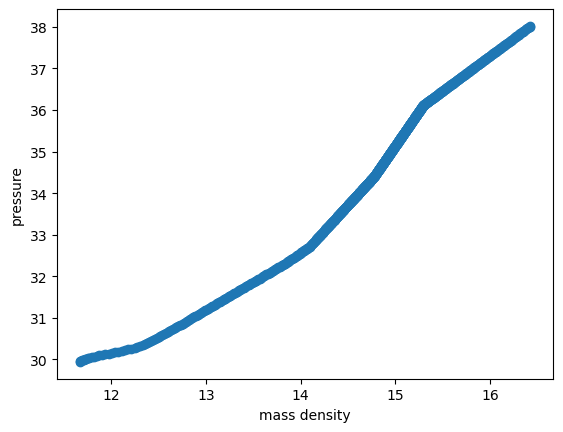

In [56]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")

# EOS


Creating many EOS lines, one for each sample and then creating the logpressure log density space with it. Converting when getting p1 and p2 values.

Progress : 0 / 40000, 0.00%
Progress : 1000 / 40000, 2.50%
Progress : 2000 / 40000, 5.00%
Progress : 3000 / 40000, 7.50%
Progress : 4000 / 40000, 10.00%
Progress : 5000 / 40000, 12.50%
Progress : 6000 / 40000, 15.00%
Progress : 7000 / 40000, 17.50%
Progress : 8000 / 40000, 20.00%
Progress : 9000 / 40000, 22.50%
Progress : 10000 / 40000, 25.00%
Progress : 11000 / 40000, 27.50%
Progress : 12000 / 40000, 30.00%
Progress : 13000 / 40000, 32.50%
Progress : 14000 / 40000, 35.00%
Progress : 15000 / 40000, 37.50%
Progress : 16000 / 40000, 40.00%
Progress : 17000 / 40000, 42.50%
Progress : 18000 / 40000, 45.00%
Progress : 19000 / 40000, 47.50%
Progress : 20000 / 40000, 50.00%
Progress : 21000 / 40000, 52.50%
Progress : 22000 / 40000, 55.00%
Progress : 23000 / 40000, 57.50%
Progress : 24000 / 40000, 60.00%
Progress : 25000 / 40000, 62.50%
Progress : 26000 / 40000, 65.00%
Progress : 27000 / 40000, 67.50%
Progress : 28000 / 40000, 70.00%
Progress : 29000 / 40000, 72.50%
Progress : 30000 / 40000, 7

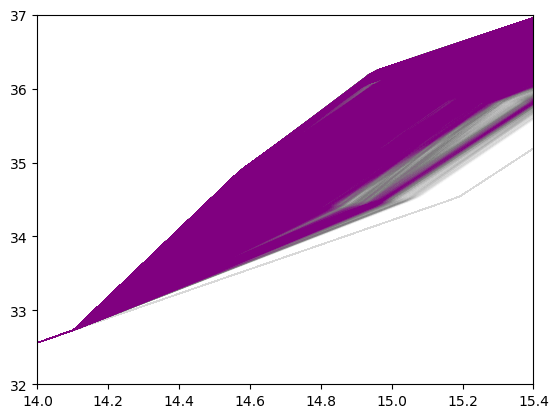

0


In [57]:
length = len(predictions)

hlow_0 = 0.022460530117115313 #?
hlow_1 = 0.024210313916473953 #?
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        g1 = float(predictions[i][1])
        g2 = float(predictions[i][2])
        p1 = float(predictions[i][3] -1)
        p2 = float(predictions[i][4] -1)

        if i%1000==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.005)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

# Actual Values EOS

Re-importing the initial data under different names

In [55]:
l1 = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
m1 = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

gamma0 = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float) # in cgs
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float) # in cgs

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

# this ends up excluding the last 20% of the data, but is more accurate to represent the MLA predictions because
# the predictions are based off on the first 80% of data. 
length = len(predictions)

Plotting what the EOS should actually look like, using the actual values not the predicted samples by creating an EOS and creating the logpressure & logdensity space.

Progress : 0 / 40000, 0.00%
Progress : 10 / 40000, 0.03%
Progress : 20 / 40000, 0.05%
Progress : 30 / 40000, 0.07%
Progress : 40 / 40000, 0.10%
Progress : 50 / 40000, 0.12%
Progress : 60 / 40000, 0.15%
Progress : 70 / 40000, 0.18%
Progress : 80 / 40000, 0.20%
Progress : 90 / 40000, 0.22%
Progress : 100 / 40000, 0.25%
Progress : 110 / 40000, 0.27%
Progress : 120 / 40000, 0.30%
Progress : 130 / 40000, 0.33%
Progress : 140 / 40000, 0.35%
Progress : 150 / 40000, 0.38%
Progress : 160 / 40000, 0.40%
Progress : 170 / 40000, 0.43%
Progress : 180 / 40000, 0.45%
Progress : 190 / 40000, 0.47%
Progress : 200 / 40000, 0.50%
Progress : 210 / 40000, 0.53%
Progress : 220 / 40000, 0.55%
Progress : 230 / 40000, 0.57%
Progress : 240 / 40000, 0.60%
Progress : 250 / 40000, 0.62%
Progress : 260 / 40000, 0.65%
Progress : 270 / 40000, 0.68%
Progress : 280 / 40000, 0.70%
Progress : 290 / 40000, 0.73%
Progress : 300 / 40000, 0.75%
Progress : 310 / 40000, 0.78%
Progress : 320 / 40000, 0.80%
Progress : 330 / 4000

GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure


RuntimeError: Generic failure

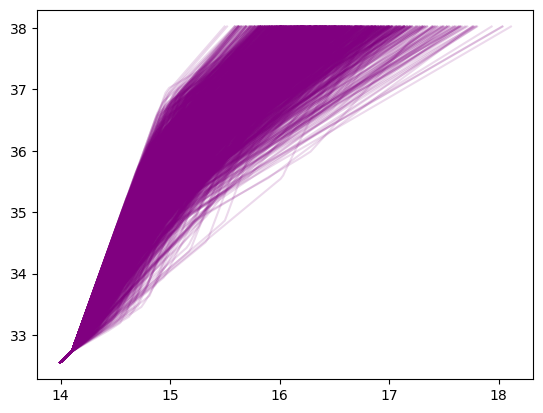

In [56]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

A review of all keys used:

In [58]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_cgs_norm_output_loss', 'logp2_cgs_norm_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_cgs_norm_output_mean_squared_error', 'logp2_cgs_norm_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_cgs_norm_output_loss', 'val_logp2_cgs_norm_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_cgs_norm_output_mean_squared_error', 'val_logp2_cgs_norm_output_mean_squared_error'])

Creating loss graphs:

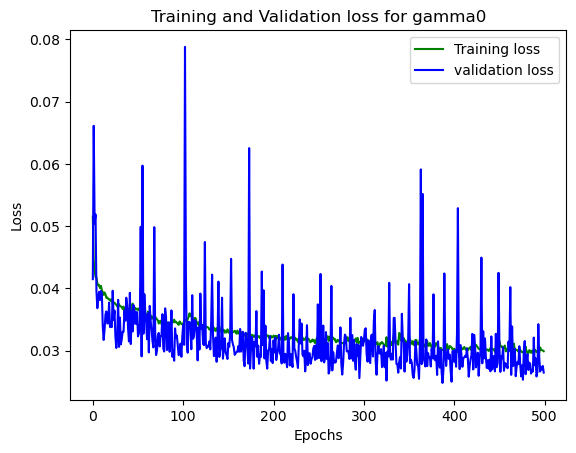

In [59]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

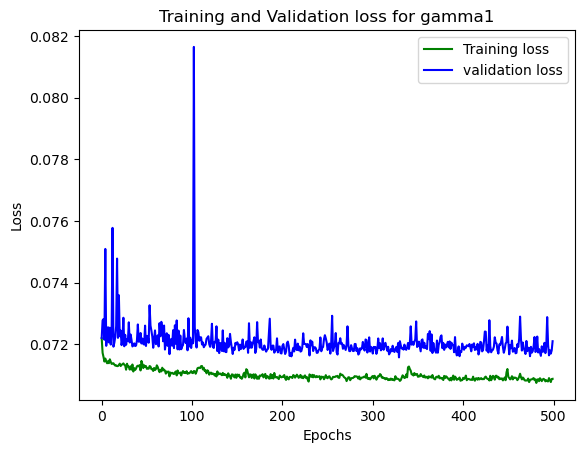

In [60]:
#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

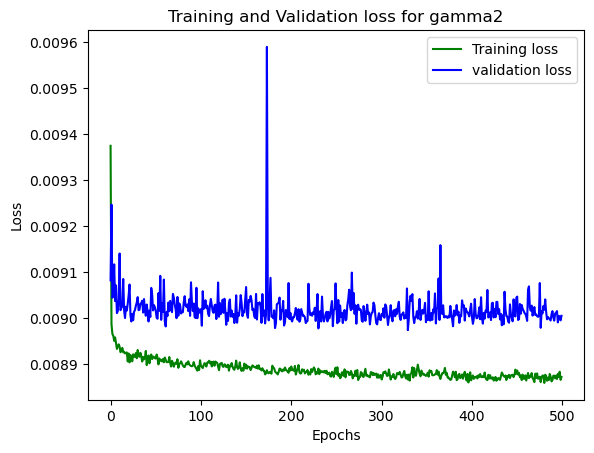

In [61]:
#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

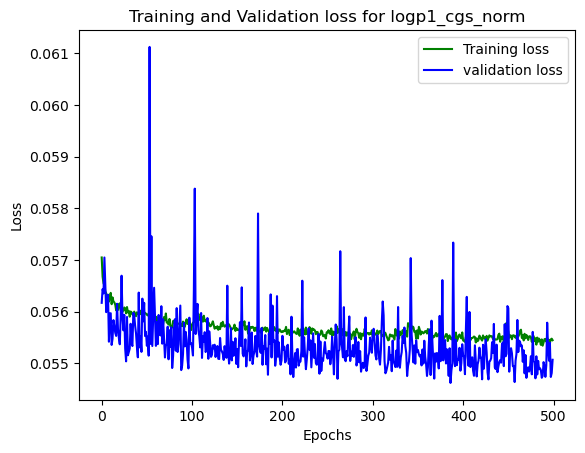

In [62]:
#loss for logp1_si values
loss_train = history.history['logp1_cgs_norm_output_loss']
loss_val = history.history['val_logp1_cgs_norm_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_cgs_norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

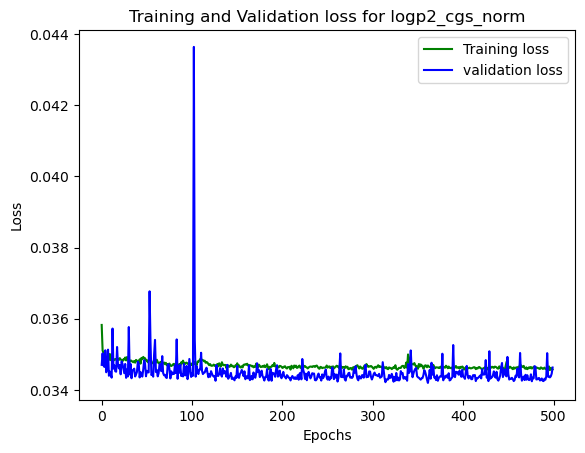

In [63]:
#loss for logp2_si values
loss_train = history.history['logp2_cgs_norm_output_loss']
loss_val = history.history['val_logp2_cgs_norm_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_cgs_norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

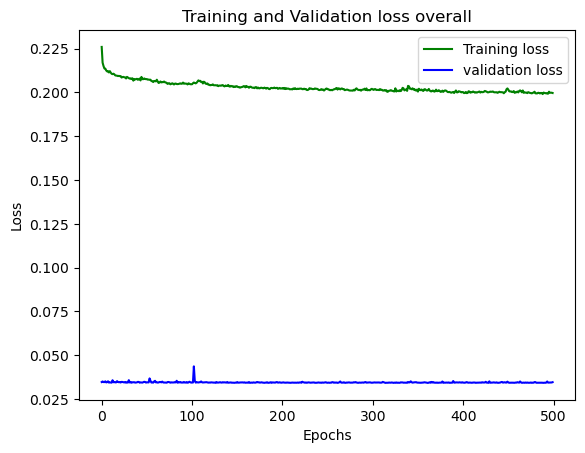

In [64]:
#overall loss
loss_train = history.history['loss']
#loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()